# Import des libraries

In [1]:
import psycopg2
import pandas as pd
import pandas.io.sql as sqlio
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns

In [2]:
pd.options.display.max_rows = 4000

# Préprocessing des données

## Ajustement des données

In [3]:
substances = ['2378-TCDD', '12378-PCDD', '123478-HxCDD', '123678-HxCDD',
       '123789-HxCDD', '1234678-HpCDD', 'OCDD', '2378-TCDF', '12378-PeCDF',
       '23478-PeCDF', '123478-HxCDF', '123678-HxCDF', '234678-HxCDF',
       '123789-HxCDF', '1234678-HpCDF', '1234789-HpCDF', 'OCDF']

substances_A = [sub + '_A' for sub in substances]
substances_C = [sub + '_C' for sub in substances]

total_homologue = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'OCDD', 
    'Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'OCDF']

total_dioxine = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'Total DIOXINE']
total_furanne = ['Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'Total FURANE']

In [4]:
data = pd.read_csv('DioxIA_20200929.csv', sep=';')

data['Type de point de mesure'].replace({"source":"Source"}, inplace=True)
data = data.replace('-', np.nan)
for col in (substances + total_homologue + ['Total DIOXINE', 'Total FURANE']):
    data[col] = data[col].astype(str)
    data[col] = [float(a.replace(',', '.')
                        .replace('94.759.846', "94759.846")
                        .replace('<', '')
                        .replace('ND', '0')
                        .replace('?', '.')
                        .replace(';', '.')
                        .replace('ç', '9')) for a in data[col].values]

In [5]:
columns_process = ['2378-TCDD', '<', '12378-PCDD', '<.1', '123478-HxCDD',
       '<.2', '123678-HxCDD', '<.3', '123789-HxCDD', '<.4', '1234678-HpCDD',
       '<.5', 'OCDD', '<.6', '2378-TCDF', '<.7', '12378-PeCDF',
       '<.8', '23478-PeCDF', '<.9', '123478-HxCDF', '<.10', '123678-HxCDF',
       '<.11', '234678-HxCDF', '<.12', '123789-HxCDF', '<.13', '1234678-HpCDF',
       '<.14', '1234789-HpCDF', '<.15', 'OCDF', '<.16',
       'Total TCDD', '<.17', 'Total PeCDD', '<.18', 'Total HxCDD', '<.19',
       'Total HpCDD', '<.20', 'Total DIOXINE', '<.21', 'Total TCDF', '<.22',
       'Total PeCDF', '<.23', 'Total HxCDF', '<.24', 'Total HpCDF', '<.25',
       'Total FURANE', '<.26']

for col in columns_process:
    if '<' in col:
        coef = []
        for a in data[col].values:
            if(a == '<' or a == 'ND' or a == 0 or a == '0'):
                coef.append(0)
            else:
                coef.append(1)
        data[old_col] = data[old_col] * coef
    else:
        old_col = col


In [6]:
data[data.duplicated()]

,Fournisseur,Nom du projet,Réf. échantillon,Réf. Synthese,Coord. Lat. Source,Coord. Long. Source,Localisation de la source,Coord. Lat. Point,Coord. Long. Point,Distance à la source (km),...,Total PeCDF,<.23,Total HxCDF,<.24,Total HpCDF,<.25,Total FURANE,<.26,Total \nDIOXINE\nFURANE,Commentaire


In [7]:
# prof = ProfileReport(data)
# prof.to_file(output_file='output.html')

## Normalisation A

In [8]:
table_final = data.copy()
table_final["total sub 2378"] = 0
for sub in substances:
    table_final["total sub 2378"] += table_final[sub]

In [9]:
table_norme_A = table_final.copy()
for sub in substances:
    table_norme_A[sub + '_A'] = table_norme_A[sub]  / table_final["total sub 2378"]

## Normalisation C

In [10]:
normalisation_C_disc = True

In [11]:
table_norme_C = table_final.copy()

for col in total_homologue:
    table_final["total homologue"] = 0
    table_final["total homologue"] += table_final[col]
table_norme_C = table_final[table_final["total homologue"] > 0]

substance_in = {}
for homologue in total_homologue:
    if(homologue != "OCDD" and homologue != "OCDF"):
        list_sub = []
        text_ref_homologue = homologue.replace("Total ", "")
        table_norme_C[text_ref_homologue] = 0
        for sub in substances:
            if sub.find(text_ref_homologue) != -1:
                list_sub.append(sub)
                table_norme_C[text_ref_homologue] += table_norme_C[sub]
        substance_in[homologue] = list_sub
        text_ref_homologue_2 = text_ref_homologue + "_2"
        table_norme_C[text_ref_homologue_2] = table_norme_C[text_ref_homologue] * 0.9
        table_norme_C = table_norme_C[table_norme_C[text_ref_homologue_2] <= table_norme_C[homologue]]
    else:
        substance_in[homologue] = [homologue]

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [12]:
table_norme_C['TOTAL PCDD'] = table_norme_C['TCDD'] + table_norme_C['PeCDD'] + table_norme_C['HxCDD'] + table_norme_C['HpCDD'] + table_norme_C['OCDD']
table_norme_C['TOTAL PCDF'] = table_norme_C['TCDF'] + table_norme_C['PeCDF'] + table_norme_C['HxCDF'] + table_norme_C['HpCDF'] + table_norme_C['OCDF'] 

for homologue in total_homologue:
    for sub in substance_in[homologue]:
        if sub == 'OCDD':
            if(normalisation_C_disc):
                table_norme_C['OCDD'] = table_norme_C['OCDD'] / table_norme_C['TOTAL PCDD']
            else:
                table_norme_C[sub] = 1
        elif sub == 'OCDF':
            if(normalisation_C_disc):
                table_norme_C['OCDF'] = table_norme_C['OCDF'] / table_norme_C['TOTAL PCDF']
            else:
                table_norme_C[sub] = 1
        else:
            table_norme_C[sub] = table_norme_C[sub] / table_norme_C[homologue]
table_norme_C = table_norme_C.fillna(0)
table_norme_C = table_norme_C.replace(np.inf, 0)
renaming = { pre : nex for (pre, nex) in zip(substances, substances_C) }
table_norme_C = table_norme_C.rename(columns = renaming)

# Analyse volumétrie

## Nombre d'échantillons

In [13]:
data_A = table_norme_A[table_norme_A["Fournisseur"] != "US EPA"]
print("Nombre d'échantillons Ineris (hors EPA) : ", len(data_A))

Nombre d'échantillons Ineris (hors EPA) :  810


In [14]:
data_C = table_norme_C[table_norme_C["Fournisseur"] != "US EPA"]
print("Nombre d'échantillons pour la normalisation C : ", len(data_C), "\nTaux restant : ", round(len(data_C) * 100 / len(data_A), 3), "%")

Nombre d'échantillons pour la normalisation C :  170 
Taux restant :  20.988 %


## Analyse des données manquantes
Variable et pourcentage de données manquantes

In [15]:
data_miss = pd.isna(data_A).replace(False, 0).replace(True, 1)
np.mean(pd.isna(data_A).replace(False, 0).replace(True, 1)) * 100

Fournisseur                           25.925926
Nom du projet                          0.000000
Réf. échantillon                       8.765432
Réf. Synthese                        100.000000
Coord. Lat. Source                     5.432099
Coord. Long. Source                    5.432099
Localisation de la source              5.432099
Coord. Lat. Point                     88.395062
Coord. Long. Point                    88.395062
Distance à la source (km)             11.481481
Typologie de l'emplacement            12.345679
Type de point de mesure                3.209877
Fiabilité donnée de l'emplacement      9.506173
Complément                            75.185185
Date de mesure :  Début               12.592593
Date de mesure :  Fin                 12.592593
Année                                  0.000000
Source                                 0.000000
Contexte                               0.000000
Matrice                                0.000000
Direction des vents dominants         20

## Fournisseurs

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


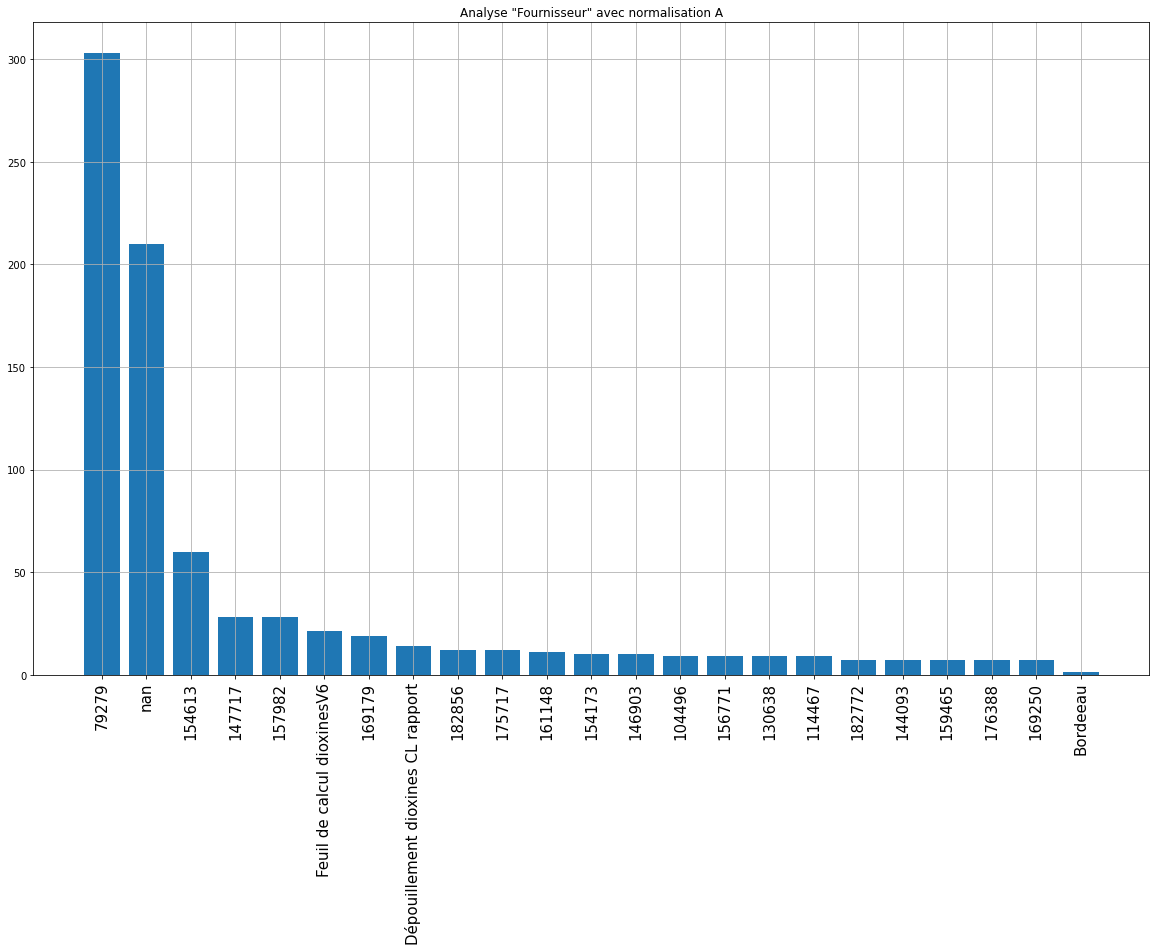

In [16]:
col = "Fournisseur"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.grid()
plt.show()

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


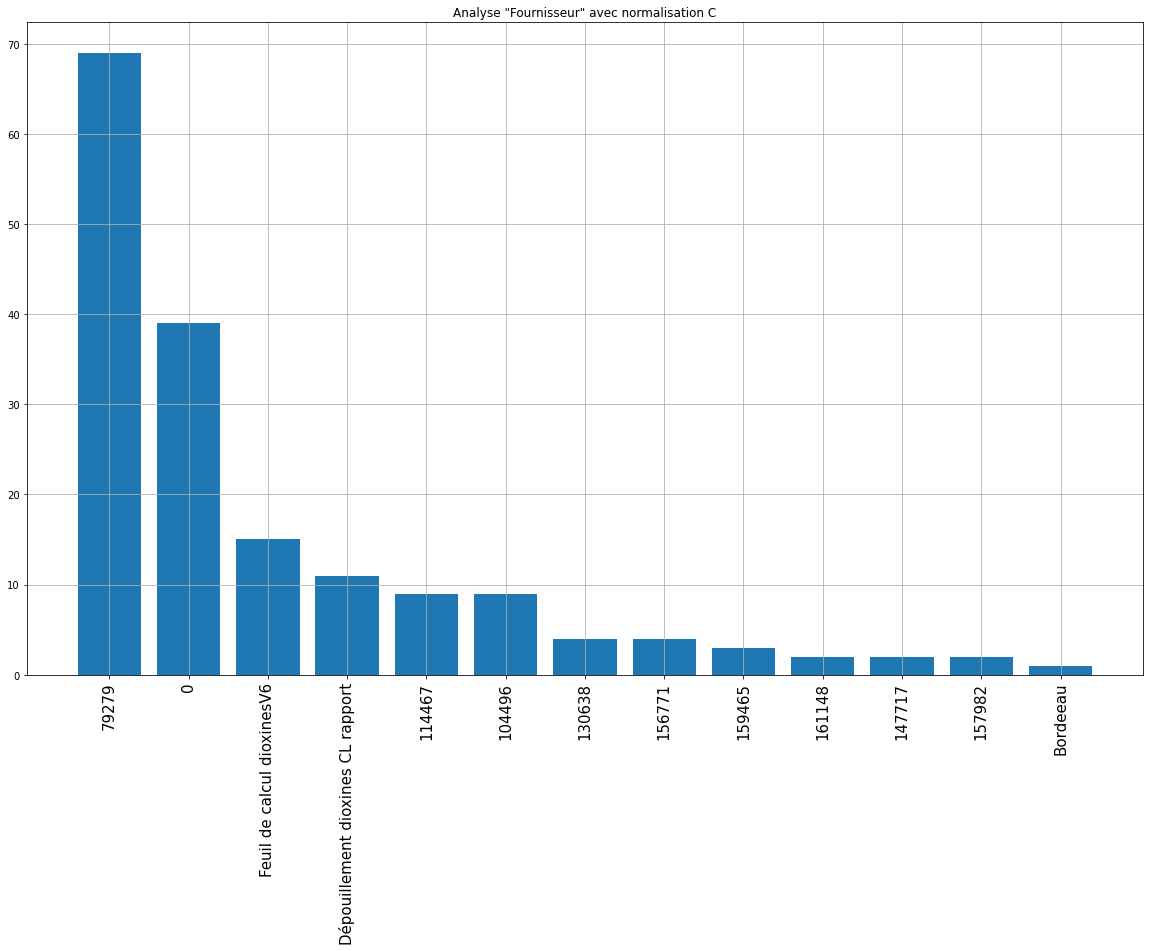

In [17]:
col = "Fournisseur"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.grid()
plt.show()

## Nom du projet

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


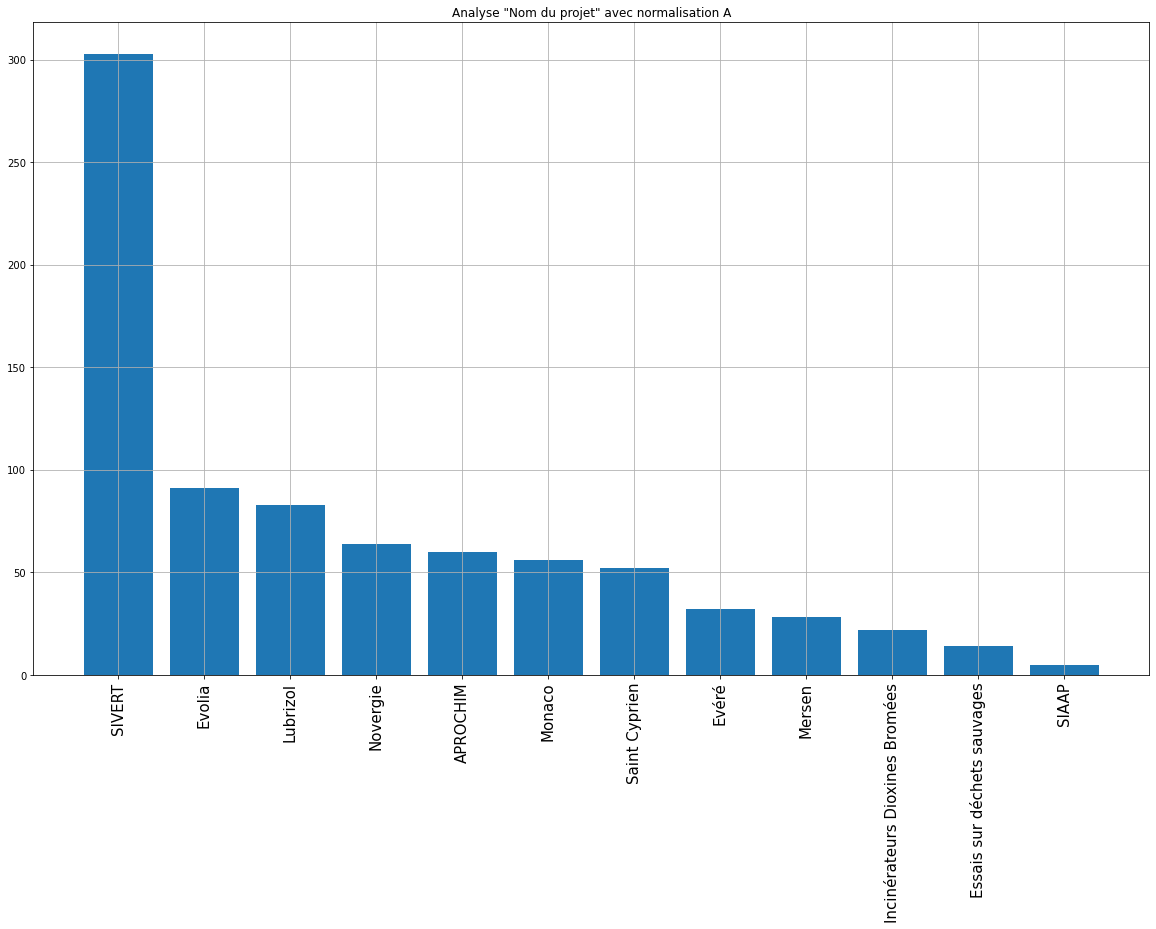

In [18]:
col = "Nom du projet"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.grid()
plt.show()

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


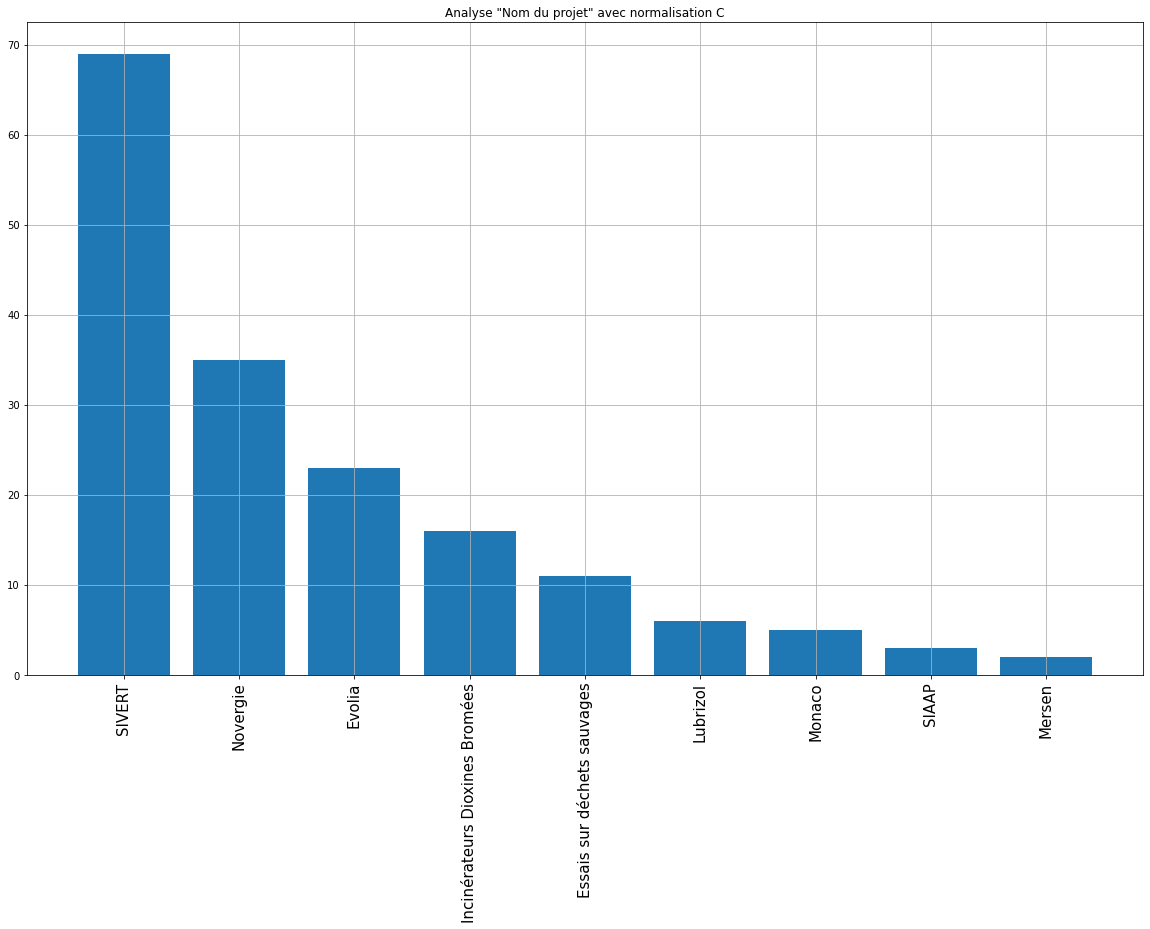

In [19]:
col = "Nom du projet"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.grid()
plt.show()

## Source

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


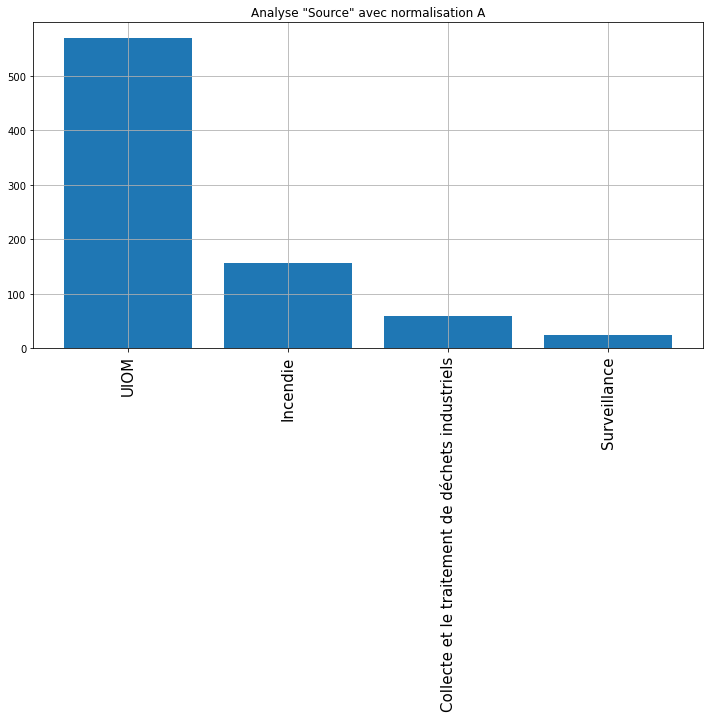

In [20]:
col = "Source"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.grid()
plt.show()

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


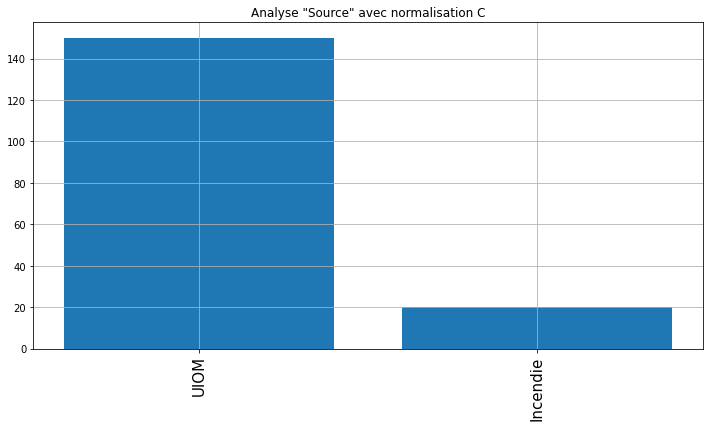

In [21]:
col = "Source"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.grid()
plt.show()

## Matrice

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


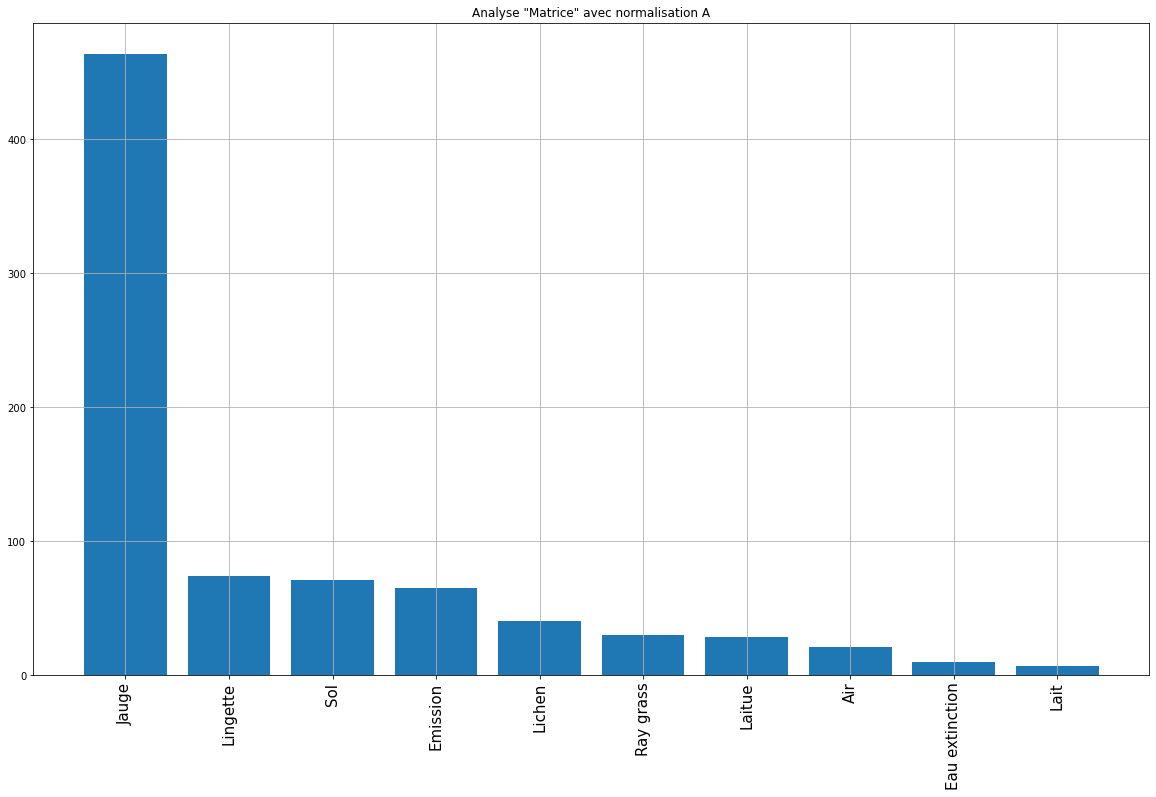

In [22]:
col = "Matrice"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.grid()
plt.show()

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


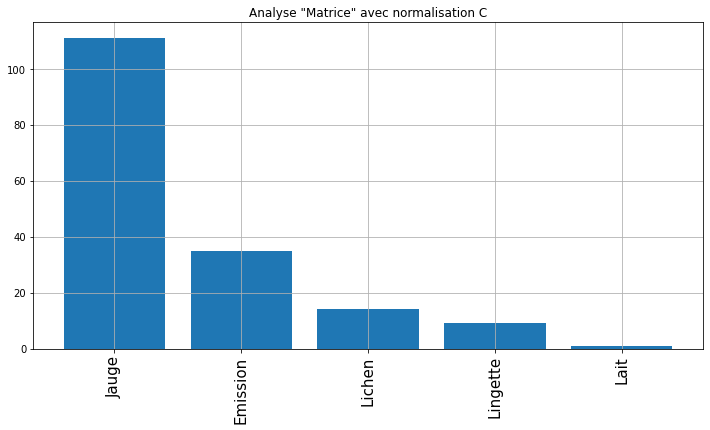

In [23]:
col = "Matrice"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.grid()
plt.show()

## Contexte

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


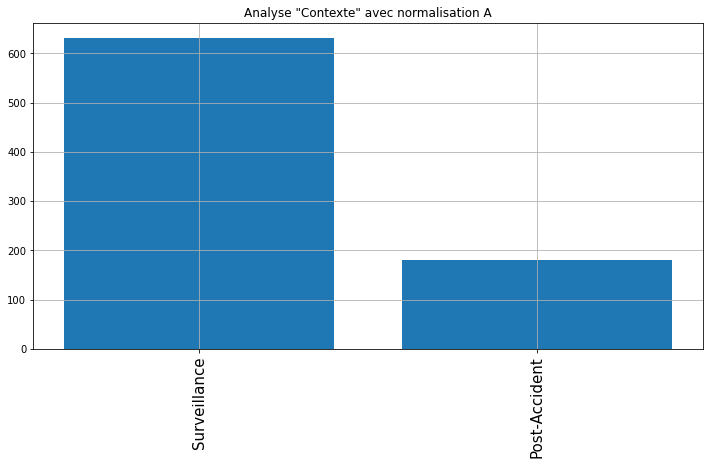

In [24]:
col = "Contexte"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.grid()
plt.show()

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


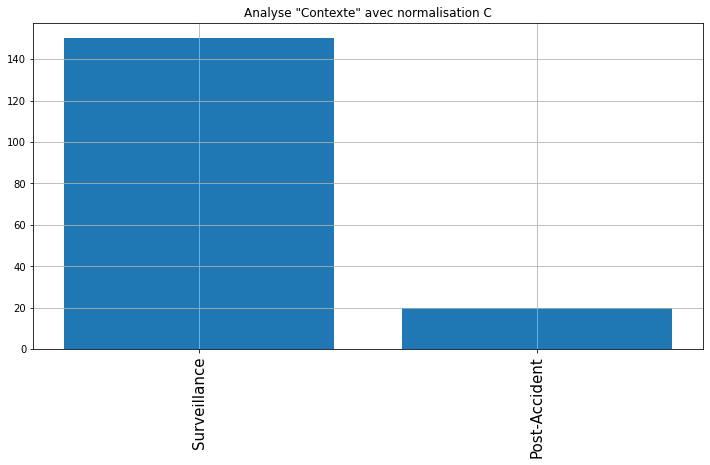

In [25]:
col = "Contexte"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.grid()
plt.show()

## Type de point de mesure

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


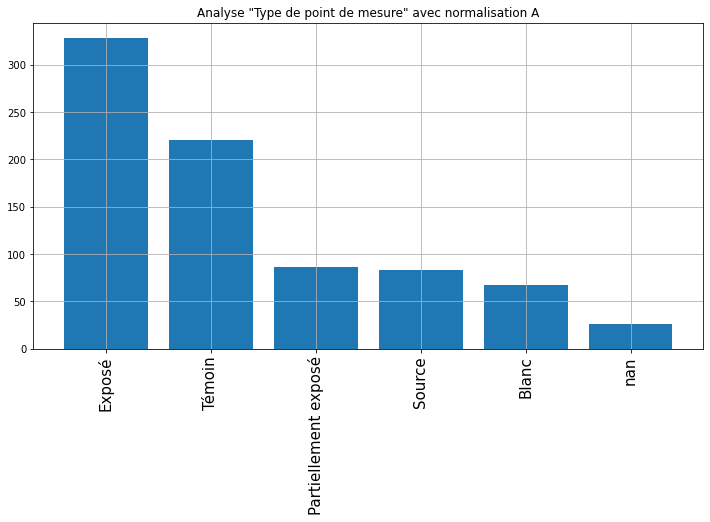

In [26]:
col = "Type de point de mesure"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.grid()
plt.show()

C:\Users\dsamy\Anaconda3\envs\ineris\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


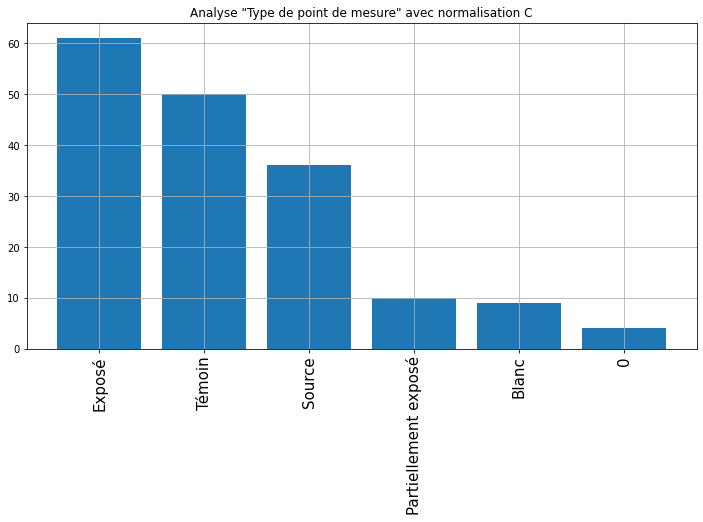

In [27]:
col = "Type de point de mesure"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.grid()
plt.show()

# Analyse de volumétrie croisée

## Analyse brute

### Matrice x Fournisseur

In [28]:
cols = ["Type de point de mesure", "Nom du projet"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]])

Nom du projet,APROCHIM,Essais sur déchets sauvages,Evolia,Evéré,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT,Saint Cyprien
Type de point de mesure,,,,,,,,,,,,
Blanc,0,0,6,0,0,10,4,8,7,1,31,0
Exposé,47,0,41,12,0,33,10,32,38,0,92,23
Partiellement exposé,8,0,9,8,0,27,6,0,6,1,8,13
Source,0,14,3,1,22,12,0,0,0,2,26,3
Témoin,5,0,32,11,0,1,8,16,13,1,120,13
nan,0,0,0,0,0,0,0,0,0,0,26,0


In [29]:
cols = ["Type de point de mesure", "Nom du projet"]
pd.crosstab(data_C[cols[0]], data_C[cols[1]])

Nom du projet,Essais sur déchets sauvages,Evolia,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT
Type de point de mesure,,,,,,,,,
0,0,0,0,0,0,0,0,0,4
Blanc,0,0,0,1,0,1,2,1,4
Exposé,0,14,0,3,2,1,21,0,20
Partiellement exposé,0,3,0,2,0,0,5,0,0
Source,11,0,16,0,0,0,0,1,8
Témoin,0,6,0,0,0,3,7,1,33


### Matrice x Type de point de mesure

In [30]:
cols = ["Matrice", "Type de point de mesure"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]]) 

Type de point de mesure,Blanc,Exposé,Partiellement exposé,Source,Témoin,nan
Matrice,,,,,,
Air,6,5,8,0,2,0
Eau extinction,0,0,0,10,0,0
Emission,0,0,0,65,0,0
Jauge,46,225,28,0,165,0
Lait,0,7,0,0,0,0
Laitue,1,13,0,0,14,0
Lichen,0,6,1,0,7,26
Lingette,9,30,28,5,2,0
Ray grass,5,10,0,0,15,0


In [31]:
cols = ["Matrice", "Type de point de mesure"]
pd.crosstab(data_C[cols[0]], data_C[cols[1]])

Type de point de mesure,0,Blanc,Exposé,Partiellement exposé,Source,Témoin
Matrice,,,,,,
Emission,0,0,0,0,35,0
Jauge,0,7,53,8,0,43
Lait,0,0,1,0,0,0
Lichen,4,0,4,0,0,6
Lingette,0,2,3,2,1,1


### Matrice x Contexte

In [32]:
cols = ["Matrice", "Contexte"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]])

Contexte,Post-Accident,Surveillance
Matrice,,
Air,9,12
Eau extinction,10,0
Emission,14,51
Jauge,6,458
Lait,0,7
Laitue,0,28
Lichen,4,36
Lingette,74,0
Ray grass,0,30


In [33]:
cols = ["Matrice", "Contexte"]
pd.crosstab(data_C[cols[0]], data_C[cols[1]])

Contexte,Post-Accident,Surveillance
Matrice,,
Emission,11,24
Jauge,0,111
Lait,0,1
Lichen,0,14
Lingette,9,0


### Matrice x Nom du projet

In [34]:
cols = ["Matrice", "Nom du projet"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]])

Nom du projet,APROCHIM,Essais sur déchets sauvages,Evolia,Evéré,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT,Saint Cyprien
Matrice,,,,,,,,,,,,
Air,0,0,0,0,0,5,0,0,0,0,12,4
Eau extinction,0,0,0,1,0,9,0,0,0,0,0,0
Emission,0,14,3,0,22,0,0,0,0,0,26,0
Jauge,60,0,75,9,0,0,28,56,62,0,171,3
Lait,0,0,5,0,0,0,0,0,2,0,0,0
Laitue,0,0,0,0,0,0,0,0,0,0,28,0
Lichen,0,0,0,4,0,0,0,0,0,0,36,0
Lingette,0,0,0,0,0,69,0,0,0,5,0,0
Ray grass,0,0,0,0,0,0,0,0,0,0,30,0


In [35]:
cols = ["Matrice", "Nom du projet"]
pd.crosstab(data_C[cols[0]], data_C[cols[1]])

Nom du projet,Essais sur déchets sauvages,Evolia,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT
Matrice,,,,,,,,,
Emission,11,0,16,0,0,0,0,0,8
Jauge,0,22,0,0,2,5,35,0,47
Lait,0,1,0,0,0,0,0,0,0
Lichen,0,0,0,0,0,0,0,0,14
Lingette,0,0,0,6,0,0,0,3,0


### Source x Nom du projet

In [40]:
cols = ["Source", "Nom du projet"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]])

Nom du projet,APROCHIM,Essais sur déchets sauvages,Evolia,Evéré,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT,Saint Cyprien
Source,,,,,,,,,,,,
Collecte et le traitement de déchets industriels,60,0,0,0,0,0,0,0,0,0,0,0
Incendie,0,14,0,26,0,83,0,0,0,5,0,28
Surveillance,0,0,0,0,0,0,0,0,0,0,0,24
UIOM,0,0,91,6,22,0,28,56,64,0,303,0


## Analyse de la contribution de l'indépendance des variables catégorielle

Haute valeur indique une dépendance pour ces valeurs

In [36]:
def chi2_test(contingency_df: pd.DataFrame, verbose: bool=True):
    """
    Perform a chi square independance test between two categorical variables
    
    contingency_df: DataFrame of contingency matrix between two categorical variables
    verbose: verbose
    """
    
    st_chi2, st_p, st_dof, st_exp = chi2_contingency(contingency_df)
    
    if verbose:
        print(f"test statistic: {st_chi2}")
        print(f"test p-value: {st_p}")
        print(f"degree of freedom: {st_dof}")
    
    return st_chi2, st_p, st_dof

def chi2_non_independance_contrib_plot(contingency_df: pd.DataFrame, len_data: int, figsize:tuple=(12, 10)):
    """a
    Plot heatmap of non independance contribution of categorical variables elements.
    High value indicates strong contribution to non independance.
    
    contingency_df: DataFrame of contingency matrix between two categorical variables
    len_data: length of the dataset
    
    https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
    """
    
    fig = plt.figure(figsize=figsize)
    tx = pd.DataFrame(contingency_df.sum(axis=1))
    ty = pd.DataFrame(contingency_df.sum(axis=0)).T
    n = len_data
    indep = tx.dot(ty) / n

    c = contingency_df.fillna(0) 
    measure = (c-indep)**2/indep
    xi_n = measure.sum().sum()
    table = measure/xi_n
    sns.heatmap(table, annot=table, cmap='RdPu', ax=fig.gca())
    #plt.tight_layout()
    plt.show()

### Matrice x Type de point de mesure

test statistic: 1422.8691293881805
test p-value: 9.66085594433464e-269
degree of freedom: 45


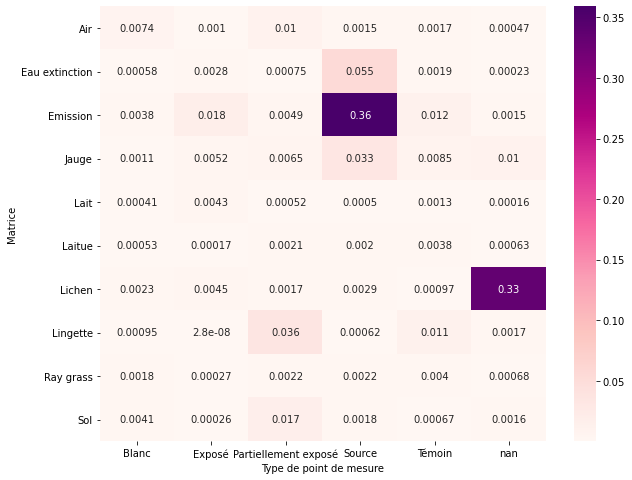

In [37]:
cols = ["Matrice", "Type de point de mesure"]

domain_measure_cross_df = pd.crosstab(data_A[cols[0]], data_A[cols[1]], margins=True)
_ = chi2_test(domain_measure_cross_df.iloc[:-1, :-1], verbose=True)
chi2_non_independance_contrib_plot(domain_measure_cross_df.iloc[:-1, :-1], len(data_A), figsize=(10, 8))

### Matrice x Nom du projet

test statistic: 1969.5919702911488
test p-value: 0.0
degree of freedom: 99


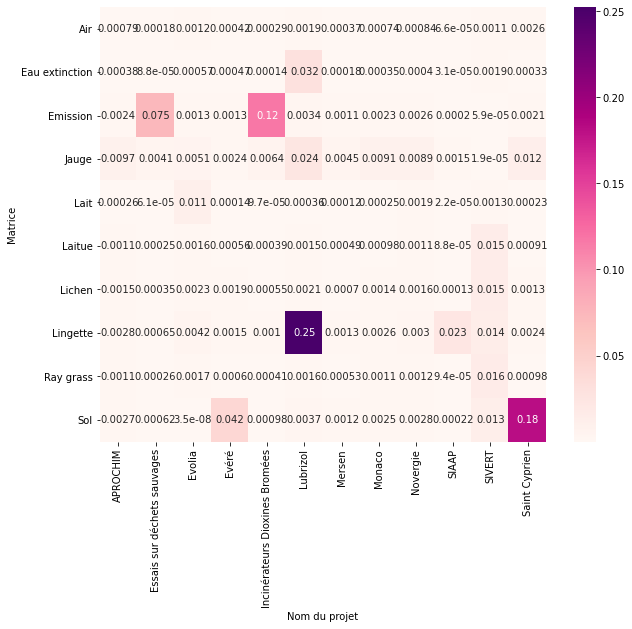

In [38]:
cols = ["Matrice", "Nom du projet"]

domain_measure_cross_df = pd.crosstab(data_A[cols[0]], data_A[cols[1]], margins=True)
_ = chi2_test(domain_measure_cross_df.iloc[:-1, :-1], verbose=True)
chi2_non_independance_contrib_plot(domain_measure_cross_df.iloc[:-1, :-1], len(data_A), figsize=(10, 8))

### Type de point de mesure x Nom du projet

test statistic: 585.7065654868059
test p-value: 8.005779562235352e-90
degree of freedom: 55


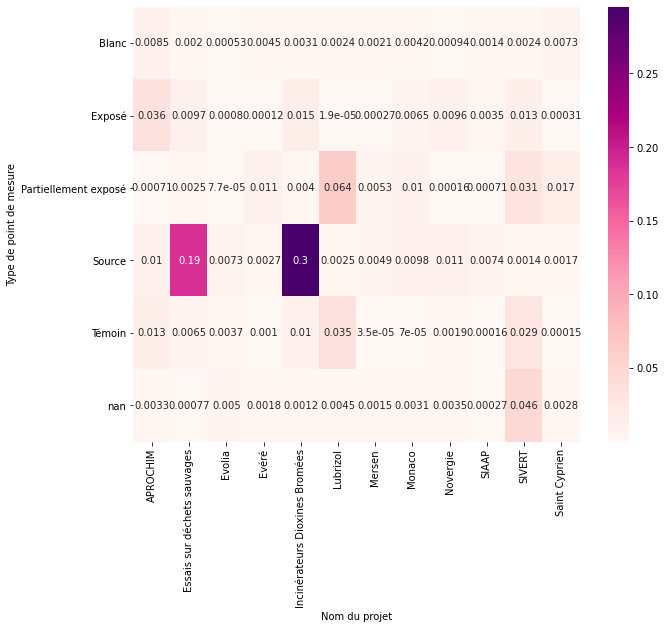

In [39]:
cols = ["Type de point de mesure", "Nom du projet"]

domain_measure_cross_df = pd.crosstab(data_A[cols[0]], data_A[cols[1]], margins=True)
_ = chi2_test(domain_measure_cross_df.iloc[:-1, :-1], verbose=True)
chi2_non_independance_contrib_plot(domain_measure_cross_df.iloc[:-1, :-1], len(data_A), figsize=(10, 8))